KERDOUN WASSIM

-----------------------------

# CASE STUDY : VOLATILITY MODELING FOR EXCHANGE RATE RETURNS

In [3]:
#load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from scipy import stats
from scipy.stats import norm, t
import warnings
warnings.filterwarnings('default')

%matplotlib inline

plt.rcParams['figure.figsize']=(16,6)
plt.rcParams['axes.grid']=True

In [4]:
#load tickers

data = pd.read_csv(r"C:\Users\wassim\Documents\Projects\VOLATILITY MODELING FOR EXCHANGE RATE RETURNS\Data\DEXUSEU.csv",parse_dates=['DATE'],index_col='DATE')
data['DEXUSEU'] = pd.to_numeric(data['DEXUSEU'], errors='coerce')
data.dropna(inplace=True)

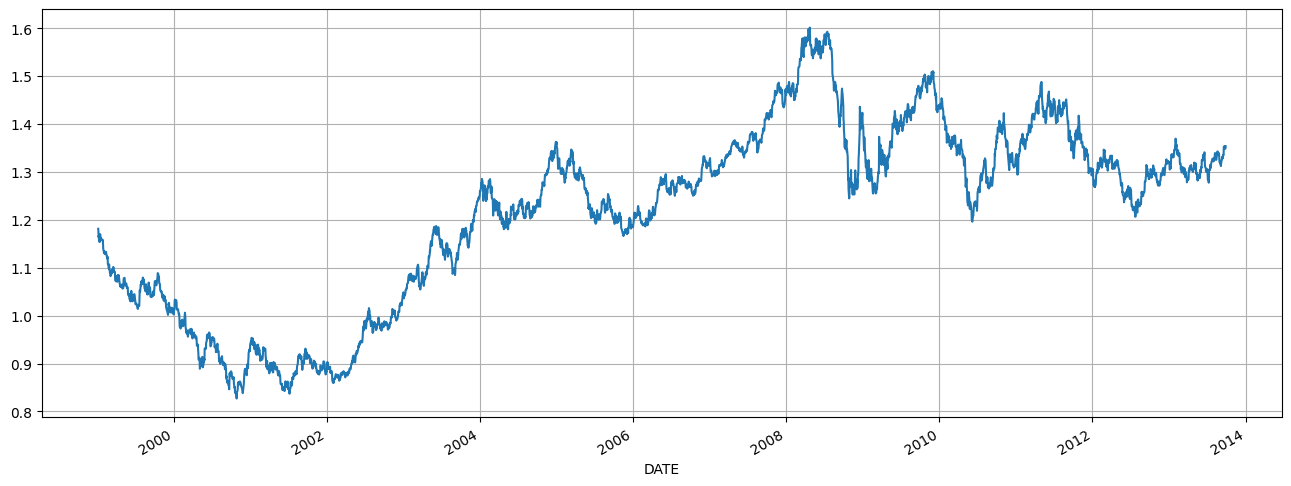

In [5]:
data['DEXUSEU'].plot()

plt.grid(True)

In [6]:
data['log_return'] = np.log(data['DEXUSEU']/data['DEXUSEU'].shift(1))

data.dropna(inplace=True)

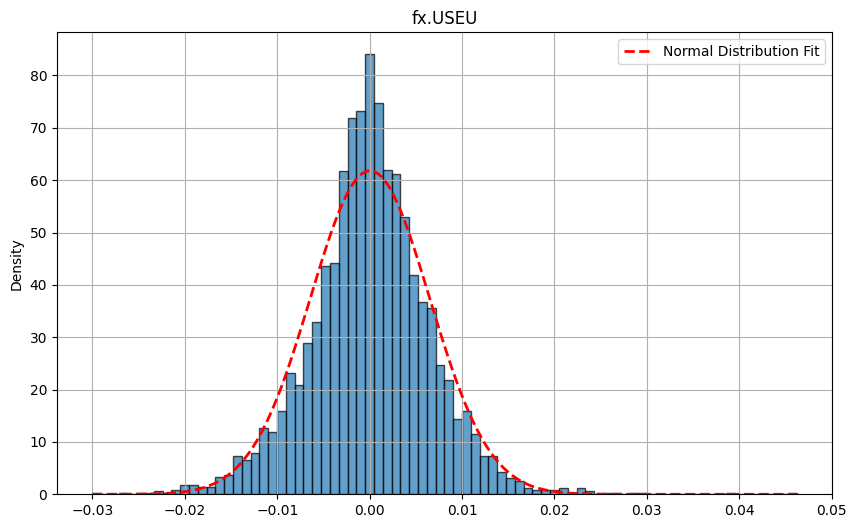

In [7]:
def hist_plot(returns,title='fx.USEU'):
    """
    Plots a histogram of returns with a normal distribution fit.
    
    Parameters:
        returns (pd.Series or np.array): The returns data to plot.
    """

    mu, std = norm.fit(returns.dropna())
    xmin,xmax = returns.dropna().min(), returns.dropna().max()
    x = np.linspace(xmin,xmax,1000)
    p = norm.pdf(x,mu,std)

    plt.figure(figsize=(10, 6))
    plt.hist(returns.dropna(), bins=80, alpha=0.7, density=True, edgecolor='black')

    plt.plot(x, p, 'r--', linewidth=2, label='Normal Distribution Fit')
    plt.grid(True)
    plt.title(title)
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
hist_plot(data['log_return'])

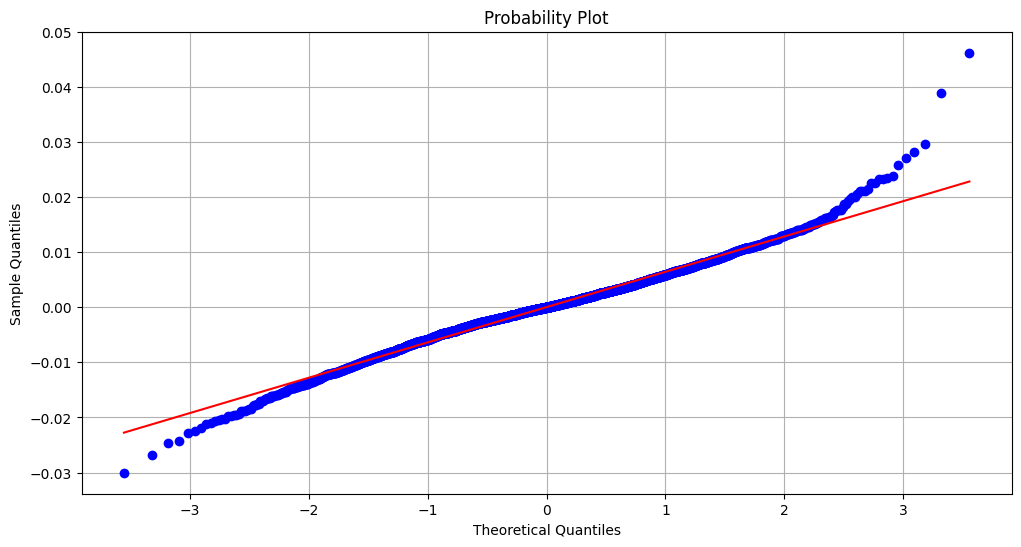

In [8]:
def qqplot(data,dist='normal',df=10):
    
    """
    Plots a Q-Q plot for the given data against a specified distribution.
    
    Parameters:
        data (pd.Series or np.array): The data to be plotted.
        dist (str): The distribution to compare against. Default is 'norm' for normal distribution.
        df (int): degree of freedom in case you are working with t-distribution
    """ 
    
    data = data.dropna()
    
    plt.figure(figsize=(12,6))
    
    if dist == 'normal':
        stats.probplot(data,dist='norm',plot=plt)
        
    elif dist == 'studentst':
        if df is None:
            raise ValueError("Degrees of freedom (df) must be provided for the Student's t-distribution.")
        stats.probplot(data, dist='t', sparams=(df,), plot=plt)
 
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
 
    plt.grid(True)
    plt.show()
    
qqplot(data['log_return'],dist='normal')

### Geometric Brownian Motion Model: Time Scales and Percentile Analysis :

The Geometric Brownian Motion (GBM) model can be analyzed under two different time scales: trading days and calendar days. Returns over weekends and holidays typically exhibit larger variances compared to overnight returns during the week when using the calendar days time scale. 

The following function compares the parameter estimates under these two time scales. Histograms of the fitted percentiles are presented for both models. If the data indeed arise from the assumed model, the fitted percentiles should be uniformly distributed.

A horizontal line representing the uniform distribution is drawn for comparison. Note that the 1\% percentile of the fitted Gaussian Distribution for Trading Days is exceeded negatively more often than expected. This indicates a heavier down-side tail distribution compared to a Gaussian distribution.

In contrast, the same percentile fitted on the Calendar Days time scale is exceeded approximately as expected. This suggests that the Calendar Days time scale better captures the typical distribution characteristics of the returns in this case.


In [9]:
def gbm_time_scale_analysis(returns, trading_days_per_year=252, clock_time_per_year=365):
    """
    Analyze Geometric Brownian Motion (GBM) model under trading days and clock time scales.
    
    Parameters:
    returns (pandas.Series): Daily returns series with a DatetimeIndex
    trading_days_per_year (int): Number of trading days in a year (default: 252)
    clock_time_hours_per_year (int): Number of hours in a year (default: 8760)
    
    Returns:
    None (displays plots and prints results)
    """
    
    mu_trading = np.mean(returns) * trading_days_per_year
    sigma_trading = np.std(returns) * np.sqrt(trading_days_per_year)
    
    mu_clock = np.mean(returns) * clock_time_per_year
    sigma_clock = np.std(returns) * np.sqrt(clock_time_per_year)
    
    percentiles_trading = norm.cdf(returns, loc=mu_trading/trading_days_per_year, 
                                         scale=sigma_trading/np.sqrt(trading_days_per_year))
    percentiles_clock = norm.cdf(returns, loc=mu_clock/clock_time_per_year, 
                                       scale=sigma_clock/np.sqrt(clock_time_per_year))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    
    ax1.hist(percentiles_trading, bins=100, density=False, alpha=0.7, color='blue', edgecolor='black')
    ax1.axhline(y=len(returns)/100, color='r', linestyle='--')
    ax1.set_title('Fitted Percentiles - Trading Days')
    ax1.set_xlabel('Percentile')
    ax1.set_ylabel('Frequency')
    
    ax2.hist(percentiles_clock, bins=100, density=False, alpha=0.7, color='green', edgecolor='black')
    ax2.axhline(y=len(returns)/100, color='r', linestyle='--')
    ax2.set_title('Fitted Percentiles - Clock Time')
    ax2.set_xlabel('Percentile')
    ax2.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
 
    exceedance_trading = np.mean(returns < norm.ppf(0.01, loc=mu_trading/trading_days_per_year, 
                                                          scale=sigma_trading/np.sqrt(trading_days_per_year)))
    exceedance_clock = np.mean(returns < norm.ppf(0.01, loc=mu_clock/clock_time_per_year, 
                                                        scale=sigma_clock/np.sqrt(clock_time_per_year)))
    
    print(f"1% Percentile Exceedance (Trading Days): {exceedance_trading:.2%}")
    print(f"1% Percentile Exceedance (Clock Time): {exceedance_clock:.2%}")
    print(f"Expected Exceedance: 1.00%")

    print("\nParameter Estimates:")
    print(f"Trading Days - μ: {mu_trading:.8f}, σ: {sigma_trading:.8f}")
    print(f"Clock Time - μ: {mu_clock:.8f}, σ: {sigma_clock:.8f}")



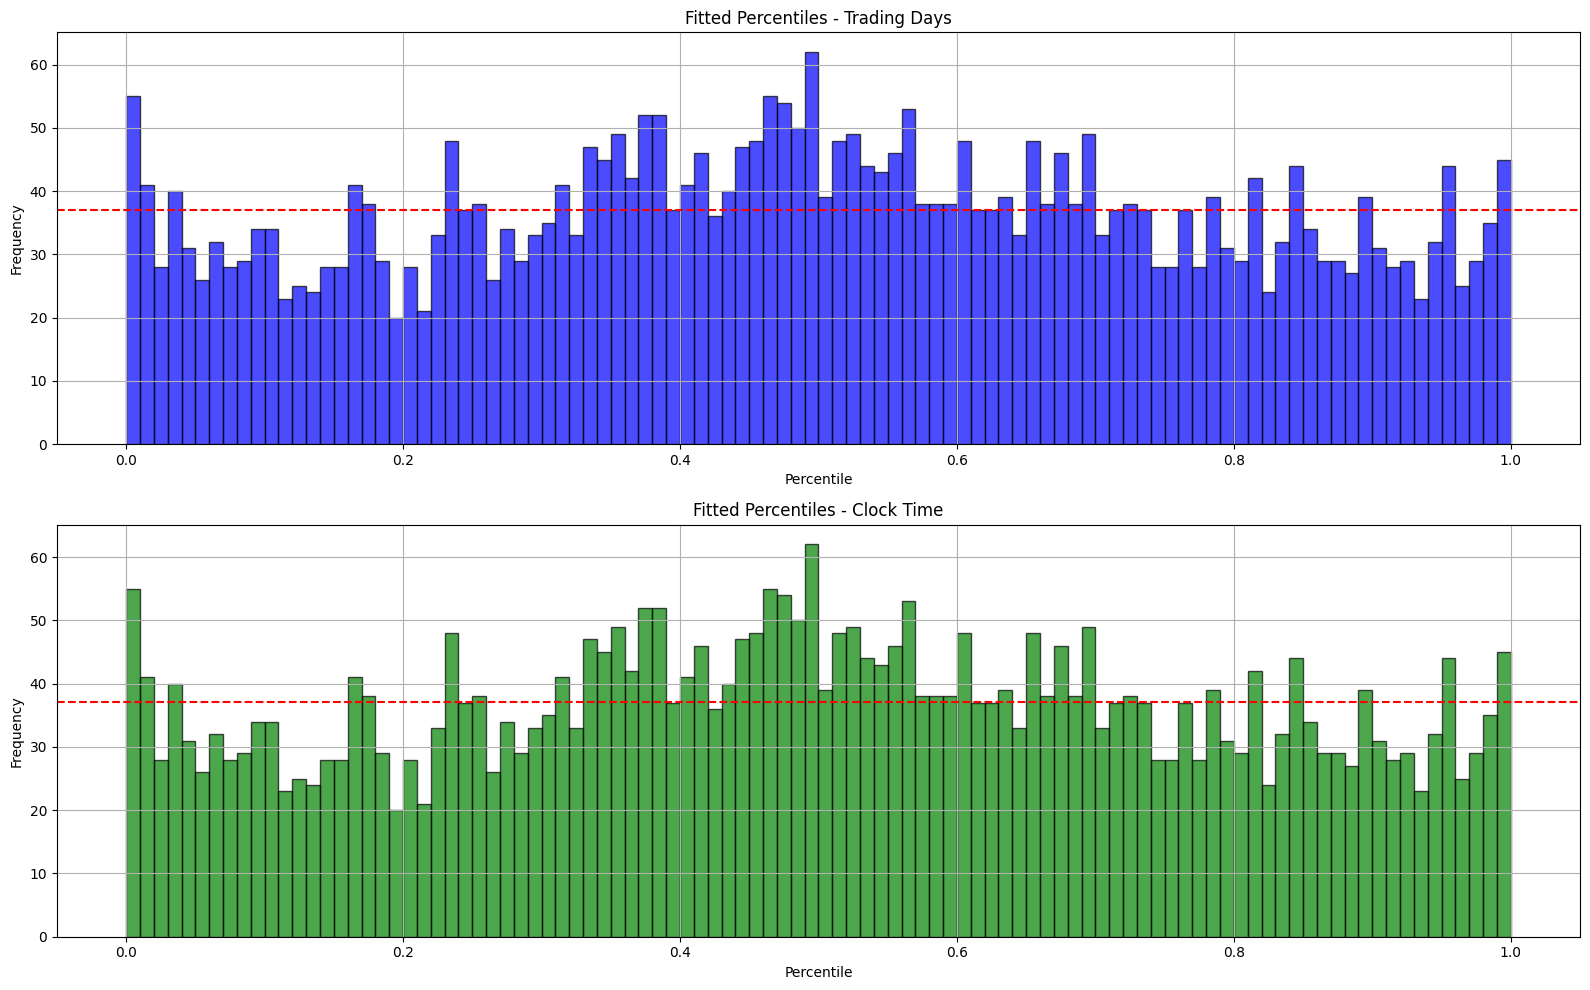

1% Percentile Exceedance (Trading Days): 1.48%
1% Percentile Exceedance (Clock Time): 1.48%
Expected Exceedance: 1.00%

Parameter Estimates:
Trading Days - μ: 0.00926383, σ: 0.10249665
Clock Time - μ: 0.01341786, σ: 0.12335474


In [10]:
gbm_time_scale_analysis(data['log_return'])

We can clearly see that the model fits well when using trading days as a time scale

<Axes: xlabel='DATE'>

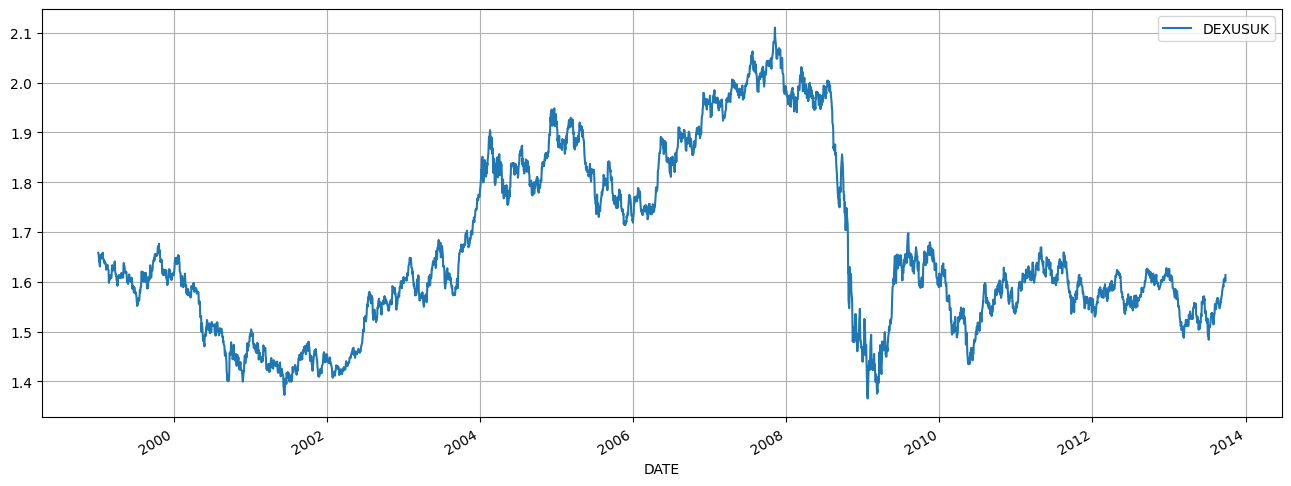

In [11]:
#let's work now on fx.gbp/usuk

usuk = pd.read_csv(r"C:\Users\wassim\Documents\Projects\VOLATILITY MODELING FOR EXCHANGE RATE RETURNS\Data\DEXUSUK.csv",parse_dates=['DATE'],index_col='DATE')

usuk['DEXUSUK'] = pd.to_numeric(usuk['DEXUSUK'],errors='coerce')

usuk.dropna(inplace=True)

usuk.plot()

<Axes: xlabel='DATE'>

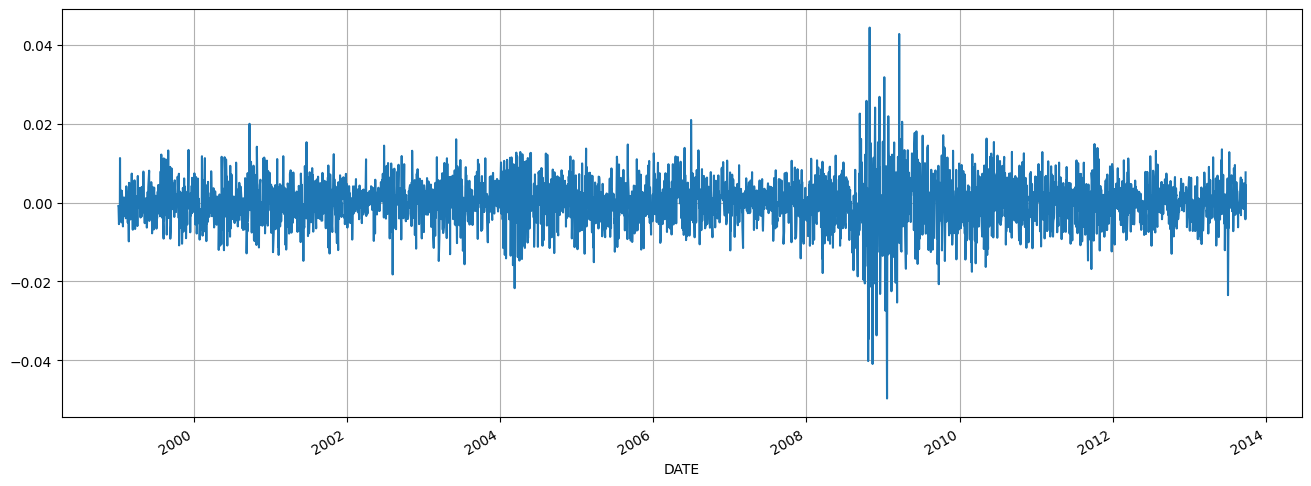

In [12]:
usuk['log_return'] = np.log(usuk['DEXUSUK']/usuk['DEXUSUK'].shift(1))

usuk.dropna(inplace=True)

usuk['log_return'].plot()

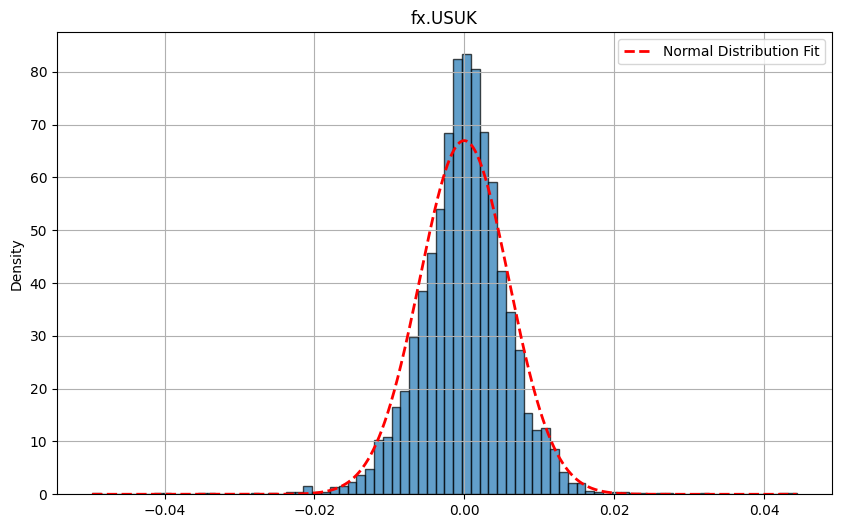

In [13]:
hist_plot(usuk['log_return'],title='fx.USUK')

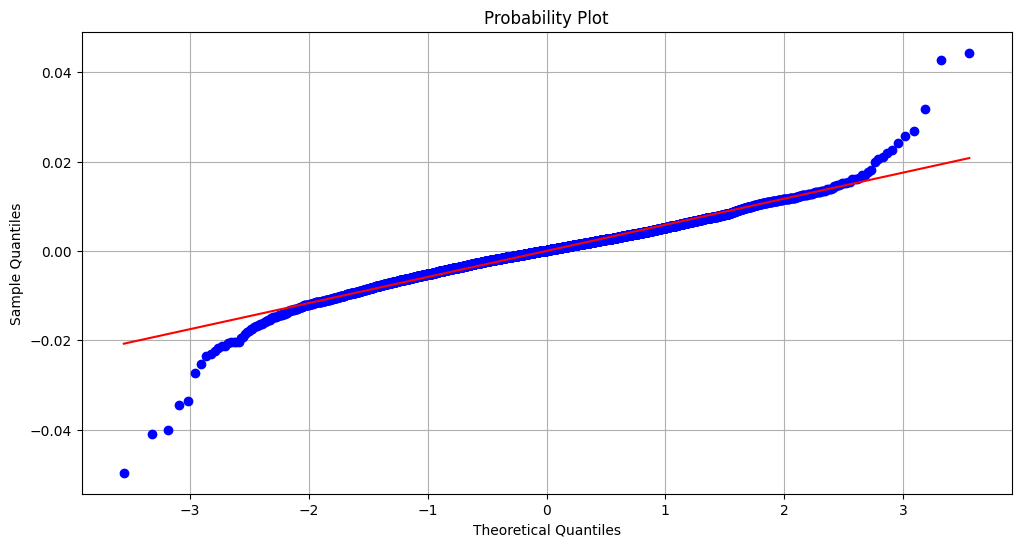

In [14]:
qqplot(usuk['log_return'],dist='normal')

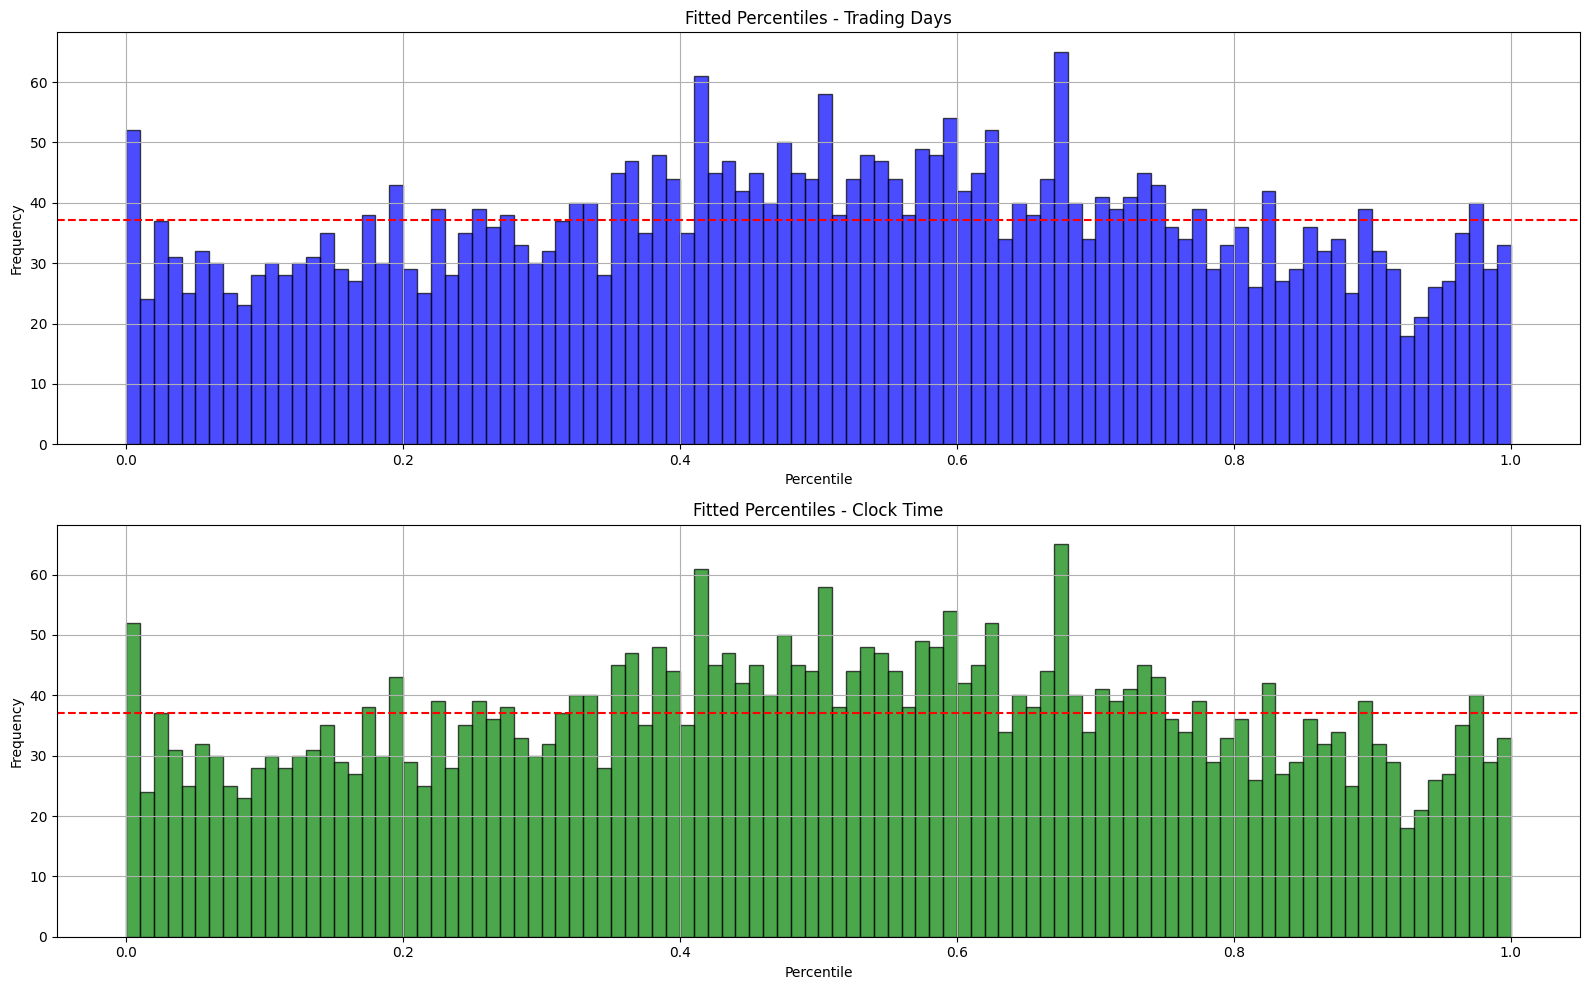

1% Percentile Exceedance (Trading Days): 1.40%
1% Percentile Exceedance (Clock Time): 1.40%
Expected Exceedance: 1.00%

Parameter Estimates:
Trading Days - μ: -0.00185307, σ: 0.09457515
Clock Time - μ: -0.00268401, σ: 0.11382121


In [15]:
gbm_time_scale_analysis(usuk['log_return'])

it is obvious that trading days approach is more accurate. This statement is justified by the lower estimated sigma in the geometric brownian motion model (gbm_model)

We can clearly see again that the trading days approach seems to follow the uniform distribution, thus, it is more accurate than the clock time approach.

Let's explore now the time dependence in Squared Returns in USUK case.

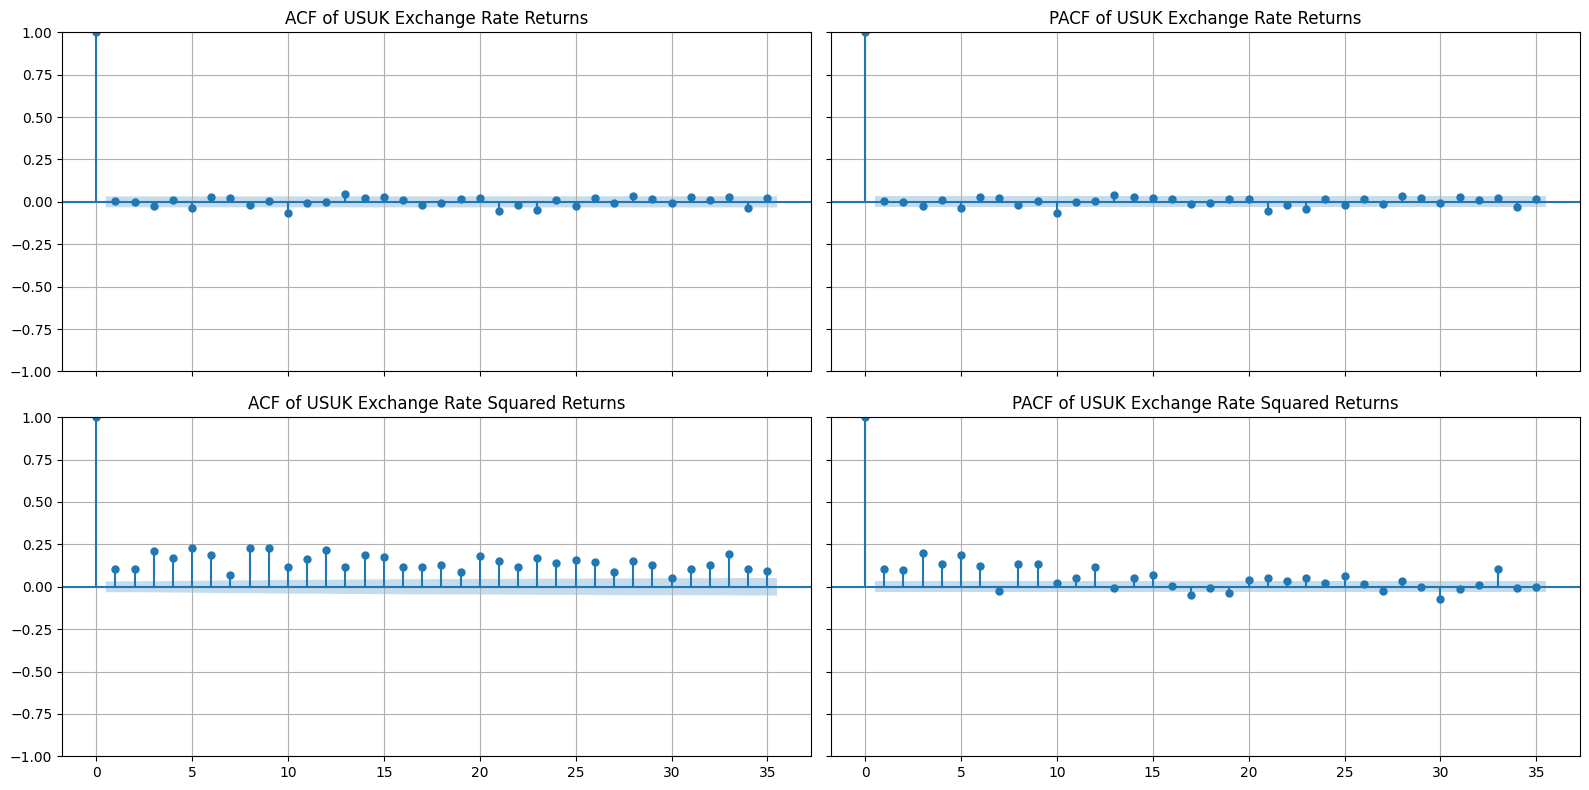

In [16]:
f, ax  = plt.subplots(2,2,figsize=(16,8),sharey=True,sharex=True)

ax = ax.flatten()

plot_acf(usuk['log_return'],ax[0],lags=35)
ax[0].set_title('ACF of USUK Exchange Rate Returns')

plot_pacf(usuk['log_return'],ax[1],lags=35)
ax[1].set_title('PACF of USUK Exchange Rate Returns')

plot_acf((usuk['log_return'])**2,ax[2],lags=35)
ax[2].set_title('ACF of USUK Exchange Rate Squared Returns')

plot_pacf((usuk['log_return'])**2,ax[3],lags=35)
ax[3].set_title('PACF of USUK Exchange Rate Squared Returns')

plt.tight_layout()

- The returns themselves appear to be uncorrelated, which is consistent with the efficient market hypothesis.
- The squared returns show evidence of volatility clustering, suggesting that an ARCH/GARCH type model might be appropriate for modeling the volatility.
- The lack of significant autocorrelation in returns but presence in squared returns suggests that while the direction of price changes might be unpredictable, the magnitude of these changes (volatility) is somewhat predictable.
- This pattern is typical for many financial time series, particularly in forex markets.

Now let's perform Gaussian ARCH and GARCH Models to predict volatility

In [17]:
def fit_arch_garch_model(returns, p=1, q=0, dist='normal',df=10):
    """
    Fit an ARCH or GARCH model to the provided returns series and perform diagnostic tests.
    
    Parameters:
    returns (pd.Series): Series of log returns.
    p (int): Order of the ARCH component. If p > 0, it fits an ARCH model. If p and q > 0, fits a GARCH model.
    q (int): Order of the GARCH component. If q > 0, it fits a GARCH model.
    
    Returns:
    fitted_model: The fitted ARCH/GARCH model.
    conditional_volatility: The conditional volatility from the fitted model.
    """
    
    returns = returns.dropna()
    
    if q == 0:
        model = arch_model(returns, vol='ARCH', p=p, dist=dist)
        
    elif q > 0:
        
        model = arch_model(returns, vol='GARCH', p=p, q=q, dist=dist)
    else:
        
        raise ValueError("q must be greater than 0 for a GARCH model")
    
    fitted_model = model.fit(disp='off')

    conditional_volatility = fitted_model.conditional_volatility
    residuals = fitted_model.resid

    print("\nDiagnostic Results:")
    
    # Ljung-Box test on squared residuals
    lb_test_squared_residuals = acorr_ljungbox(residuals**2, lags=[10], return_df=True)
    print("\nLjung-Box Test on Squared Residuals:")
    print(lb_test_squared_residuals)
    
    # Bera-Jarque test on residuals
    jb_test_residuals = jarque_bera(residuals)
    print("\nBera-Jarque Test on Residuals:")
    print(f"Test Statistic (Chi-Square): {jb_test_residuals[0]}")
    print(f"p-value: {jb_test_residuals[1]}")
    print('\n')
    
    return fitted_model, conditional_volatility

In [18]:
# Fit ARCH(1)
fitted_model_arch1, cond_vol_arch1 = fit_arch_garch_model(usuk['log_return'], p=1, q=0,dist='normal')
print(fitted_model_arch1.summary())


Diagnostic Results:

Ljung-Box Test on Squared Residuals:
        lb_stat      lb_pvalue
10  1139.604072  1.527070e-238

Bera-Jarque Test on Residuals:
Test Statistic (Chi-Square): 4410.623980430171
p-value: 0.0


                      Constant Mean - ARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                13791.9
Distribution:                  Normal   AIC:                          -27577.8
Method:            Maximum Likelihood   BIC:                          -27559.2
                                        No. Observations:                 3708
Date:                Tue, Aug 27 2024   Df Residuals:                     3707
Time:                        04:36:49   Df Model:                            1
                                  Mean Model                              

c:\Users\wassim\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.549e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [19]:
# Fit ARCH(2)
fitted_model_arch2, cond_vol_arch2 = fit_arch_garch_model(usuk['log_return'], p=2, q=0)
print(fitted_model_arch2.summary())


Diagnostic Results:

Ljung-Box Test on Squared Residuals:
       lb_stat      lb_pvalue
10  1140.40774  1.024630e-238

Bera-Jarque Test on Residuals:
Test Statistic (Chi-Square): 4410.623980430171
p-value: 0.0


                      Constant Mean - ARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                13833.6
Distribution:                  Normal   AIC:                          -27659.1
Method:            Maximum Likelihood   BIC:                          -27634.2
                                        No. Observations:                 3708
Date:                Tue, Aug 27 2024   Df Residuals:                     3707
Time:                        04:36:49   Df Model:                            1
                                  Mean Model                                

c:\Users\wassim\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.549e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [20]:
# Fit ARCH(10)
fitted_model_arch10, cond_vol_arch10 = fit_arch_garch_model(usuk['log_return'], p=10, q=0)
print(fitted_model_arch10.summary())


Diagnostic Results:

Ljung-Box Test on Squared Residuals:
        lb_stat      lb_pvalue
10  1140.814744  8.371554e-239

Bera-Jarque Test on Residuals:
Test Statistic (Chi-Square): 4410.623980430171
p-value: 0.0


                      Constant Mean - ARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                14059.2
Distribution:                  Normal   AIC:                          -28094.5
Method:            Maximum Likelihood   BIC:                          -28019.9
                                        No. Observations:                 3708
Date:                Tue, Aug 27 2024   Df Residuals:                     3707
Time:                        04:36:49   Df Model:                            1
                                  Mean Model                              

c:\Users\wassim\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.549e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [21]:
# Fit GARCH(1,1)
fitted_model_garch11, cond_vol_garch11 = fit_arch_garch_model(usuk['log_return'], p=1, q=1,dist='normal')
print(fitted_model_garch11.summary())


Diagnostic Results:

Ljung-Box Test on Squared Residuals:
       lb_stat      lb_pvalue
10  1139.13558  1.926982e-238

Bera-Jarque Test on Residuals:
Test Statistic (Chi-Square): 4410.623980430171
p-value: 0.0


                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                14089.0
Distribution:                  Normal   AIC:                          -28170.0
Method:            Maximum Likelihood   BIC:                          -28145.1
                                        No. Observations:                 3708
Date:                Tue, Aug 27 2024   Df Residuals:                     3707
Time:                        04:36:49   Df Model:                            1
                                   Mean Model                               

c:\Users\wassim\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.549e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\wassim\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


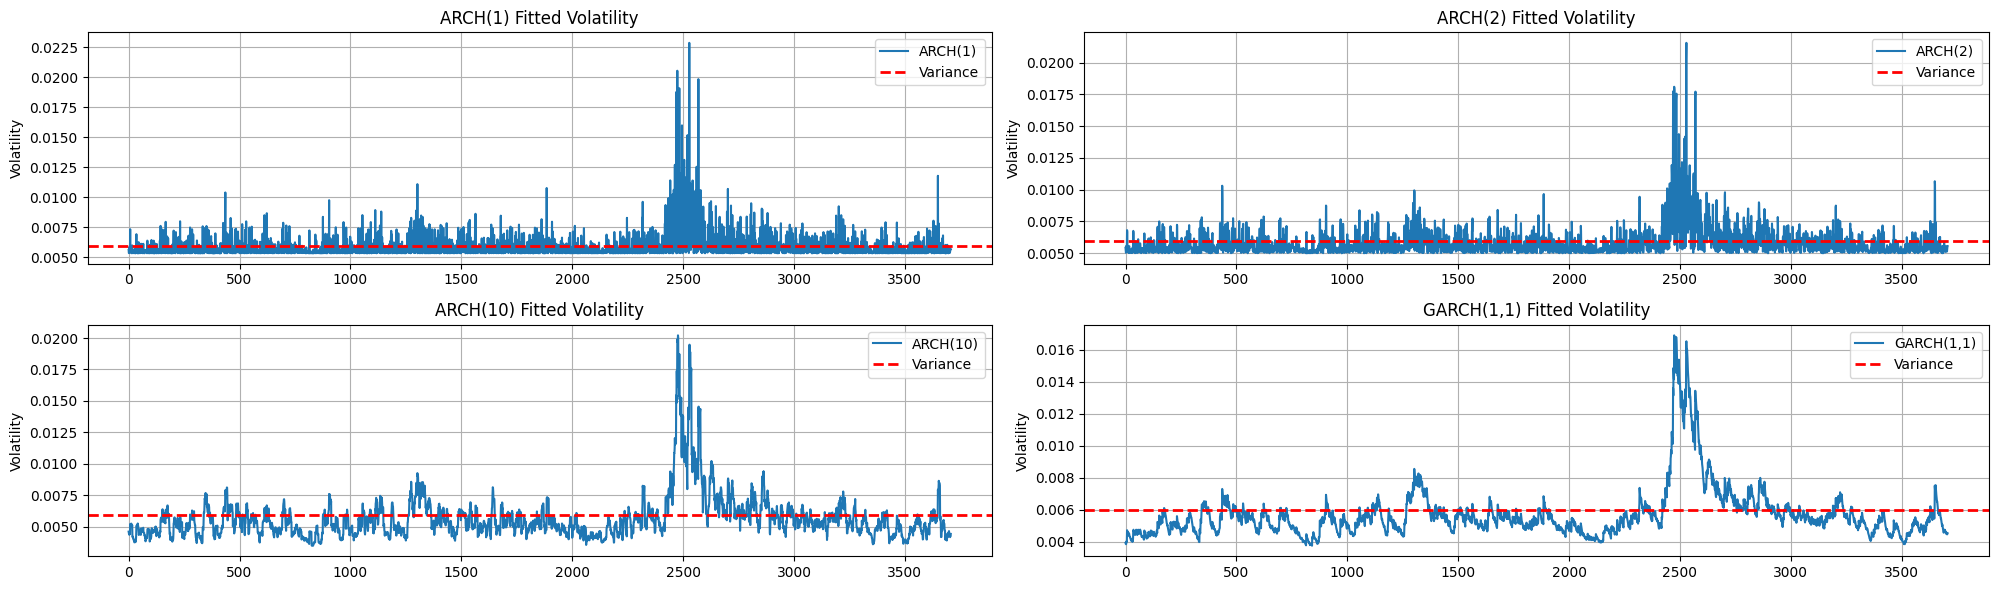

In [22]:
vol_estmat = pd.DataFrame({
    'ARCH1': cond_vol_arch1,
    'ARCH2': cond_vol_arch2,
    'ARCH10': cond_vol_arch10,
    'GARCH11': cond_vol_garch11
})

vol_estmat = vol_estmat.reset_index(drop=True)

# Calculate the variance of the returns
var_y = np.var(usuk['log_return'].dropna())

plt.figure(figsize=(20, 6))

plt.subplot(2, 2, 1)
plt.plot(vol_estmat['ARCH1'], label='ARCH(1)')
plt.axhline(y=np.sqrt(var_y), color='r', linestyle='--', linewidth=2, label='Variance')
plt.title('ARCH(1) Fitted Volatility')
plt.ylabel('Volatility')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(vol_estmat['ARCH2'], label='ARCH(2)')
plt.axhline(y=np.sqrt(var_y), color='r', linestyle='--', linewidth=2, label='Variance')
plt.title('ARCH(2) Fitted Volatility')
plt.ylabel('Volatility')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(vol_estmat['ARCH10'], label='ARCH(10)')
plt.axhline(y=np.sqrt(var_y), color='r', linestyle='--', linewidth=2, label='Variance')
plt.title('ARCH(10) Fitted Volatility')
plt.ylabel('Volatility')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(vol_estmat['GARCH11'], label='GARCH(1,1)')
plt.axhline(y=np.sqrt(var_y), color='r', linestyle='--', linewidth=2, label='Variance')
plt.title('GARCH(1,1) Fitted Volatility')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()

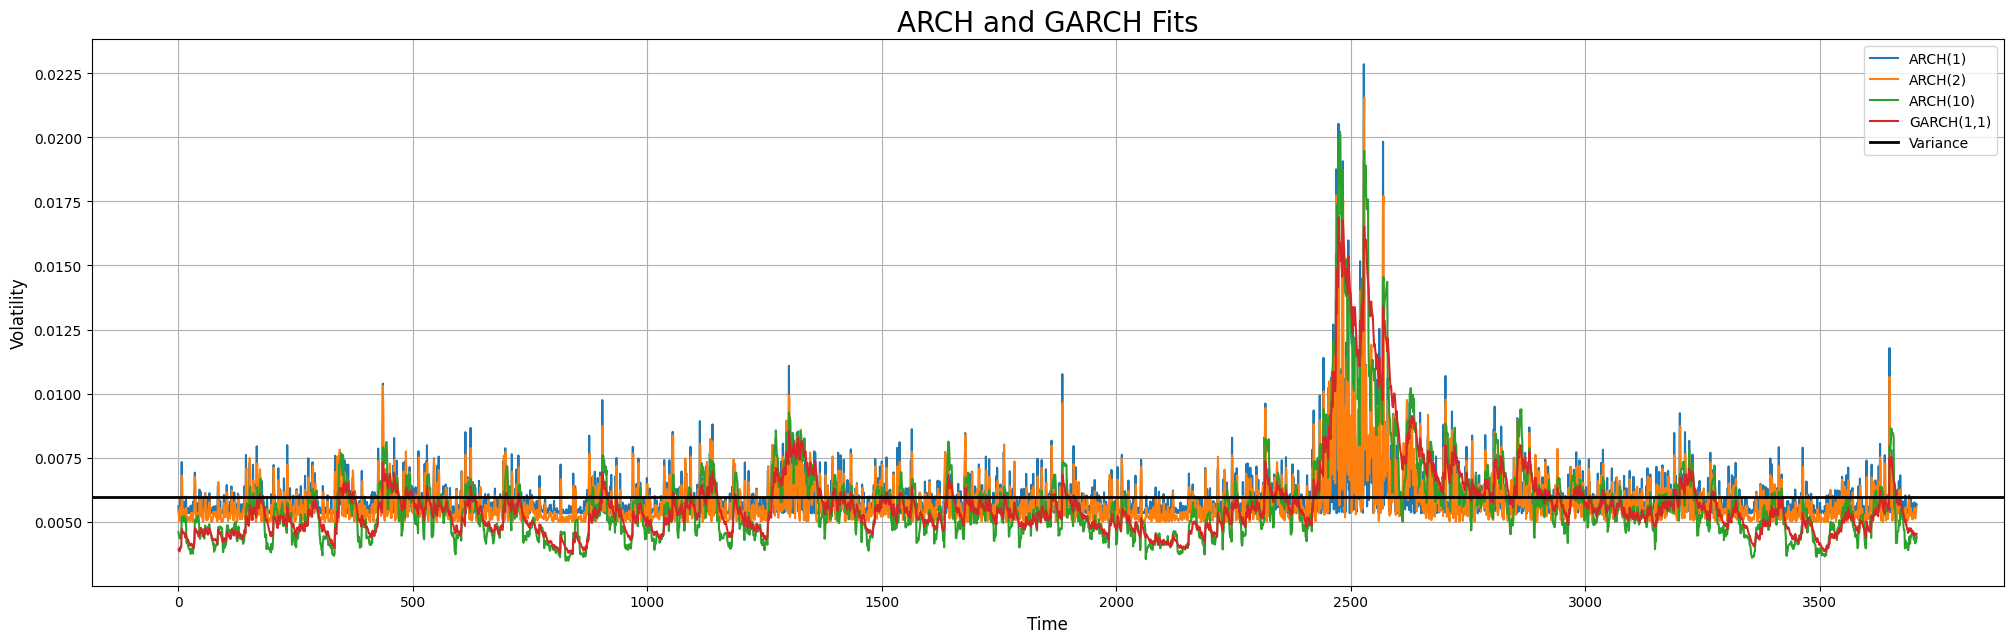

In [23]:
plt.figure(figsize=(20,6))

plt.plot(vol_estmat['ARCH1'], label='ARCH(1)')
plt.plot(vol_estmat['ARCH2'], label='ARCH(2)')
plt.plot(vol_estmat['ARCH10'], label='ARCH(10)')
plt.plot(vol_estmat['GARCH11'], label='GARCH(1,1)')
plt.axhline(y=np.sqrt(var_y), color='k', linestyle='-', linewidth=2, label='Variance')
plt.tight_layout()
plt.title('ARCH and GARCH Fits',size=20)
plt.xlabel('Time',size=12)
plt.ylabel('Volatility',size=12)
plt.legend()

### Note:

- The ARCH models have a hard lower bound (0) which gets lower with higher-order p values.
- The GARCH(1,1) model provides an extremely parsimonious model compared to that of the ARCH(10) model.
- The GARCH(1,1) model is quite smooth when compared to every ARCH model.
- The GARCH(1,1) model is close to being non-stationary : 
  Total Sum=Sum of α+Sum of β=0.1000+0.8800=0.9800 ~ 1, which means that the volatility is long lasting in our case study

### Now let's work on GARCH(1,1) Model with t-distribution

- *AR(7) Model*

In [24]:
def fit_ar_model(data, lags=7, dist='normal'):
    """
    Fits an AR model to the data and fits either a normal or Student's t-distribution to the residuals.
    
    Parameters:
    - data (pd.Series): Time series data.
    - lags (int): Number of lags to use in the AR model.
    - dist (str): Type of distribution to fit ('normal' or 't').
    
    Returns:
    - ar_fit: Fitted AR model.
    """
    data.dropna(inplace=True)
    
    ar_model = AutoReg(data, lags=lags)
    
    if dist == 'normal':
        ar_fit = ar_model.fit()
    
    elif dist == 'studentst':
        ar_fit = ar_model.fit(use_t=True)
    
    else:
        raise ValueError("Unsupported distribution. Choose 'normal' or 't'.")
    
    print('AR fit summary:')
    print(ar_fit.summary())
    
    return ar_fit

In [25]:
ar_fit = fit_ar_model(usuk['log_return'], lags=7, dist='normal')

AR fit summary:
                            AutoReg Model Results                             
Dep. Variable:             log_return   No. Observations:                 3708
Model:                     AutoReg(7)   Log Likelihood               13715.350
Method:               Conditional MLE   S.D. of innovations              0.006
Date:                Tue, 27 Aug 2024   AIC                         -27412.700
Time:                        04:36:50   BIC                         -27356.753
Sample:                             7   HQIC                        -27392.790
                                 3708                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.786e-06   9.78e-05     -0.059      0.953      -0.000       0.000
log_return.L1     0.0091      0.016      0.553      0.580      -0.023       0.041
log_return.L2     0.0006

c:\Users\wassim\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [26]:
def plot_ar_residuals(residuals,dist):
    
    plt.figure(figsize=(12, 6))
    
    standardized_residuals = (residuals - residuals.mean())/residuals.std()
    
    hist_plot(returns=standardized_residuals,title='Histogram of AR(7) Standardized Residuals')
    
    qqplot(residuals, dist=dist)
    
    plt.show()

<Figure size 1200x600 with 0 Axes>

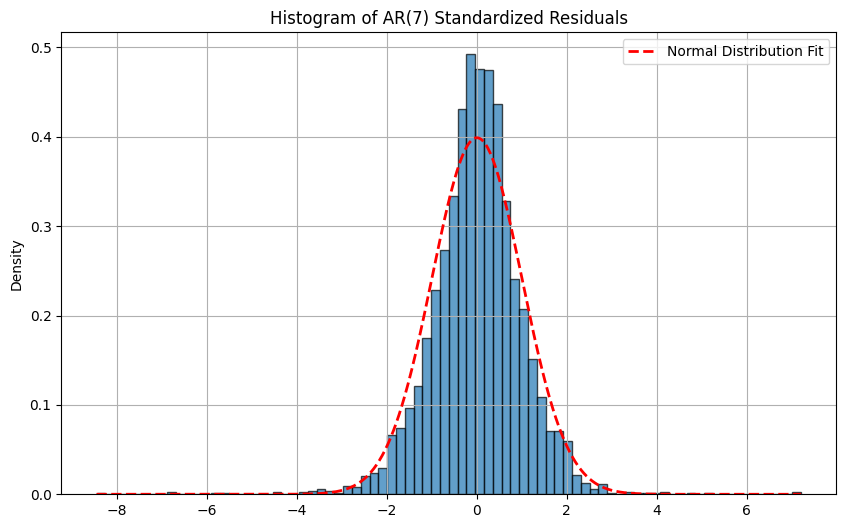

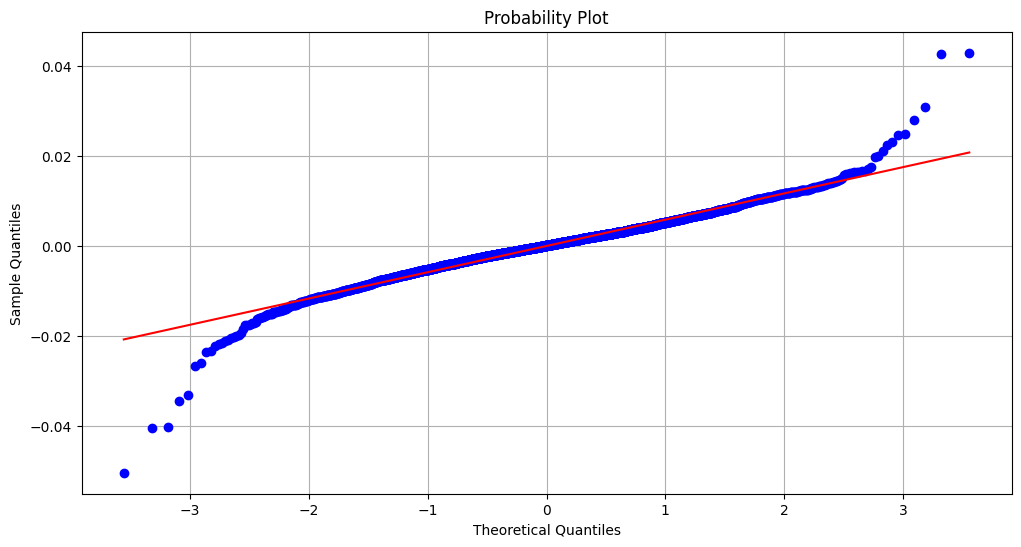

In [27]:
# Plotting AR(7) Residuals

plot_ar_residuals(ar_fit.resid,dist='normal')

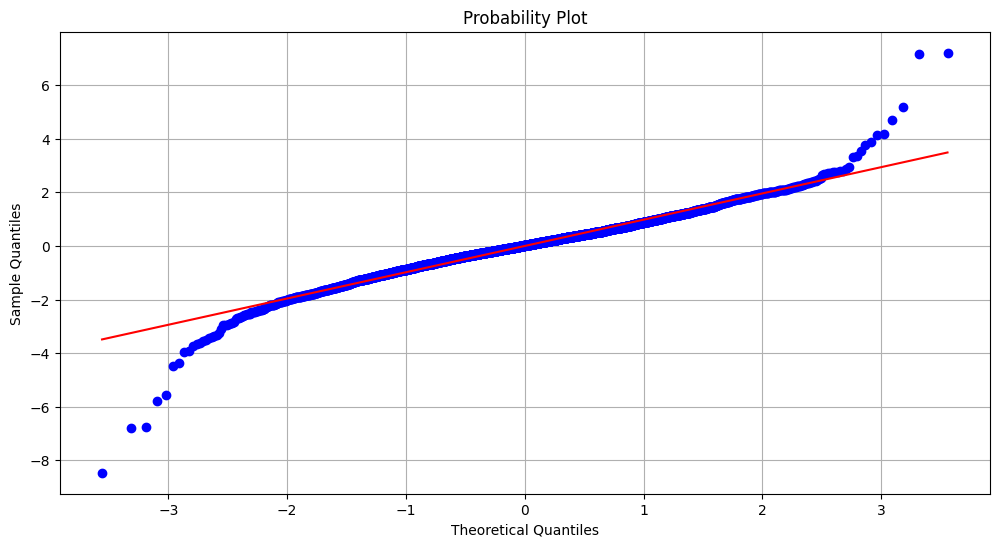

In [28]:
mean_resid = ar_fit.resid.mean()
std_resid = ar_fit.resid.std()
normalized_quantiles = (ar_fit.resid - mean_resid)/std_resid

# 'Normal Q-Q Plot of Normalized Residuals'
qqplot(normalized_quantiles,dist='normal')

- *AR(7)-GARCH(1,1) Model with Gaussian Assumption*

In [29]:
def fit_ar_garch_model(data,title, lags=7,dist='normal',p=1,q=1):
    
    ar_fit = fit_ar_model(data,lags=lags,dist=dist)
    
    residuals = ar_fit.resid
    
    garch_fit,conditional_volatility = fit_arch_garch_model(residuals,p=p,q=q,dist=dist)
    
    standardized_residuals = (garch_fit.resid - garch_fit.resid.mean())/garch_fit.resid.std()
    
    hist_plot(standardized_residuals,title='Histogram of GARCH(1,1) Residuals')
    
    qqplot(standardized_residuals,dist=dist)
    
    return ar_fit, garch_fit,conditional_volatility

AR fit summary:
                            AutoReg Model Results                             
Dep. Variable:             log_return   No. Observations:                 3708
Model:                     AutoReg(7)   Log Likelihood               -3328.385
Method:               Conditional MLE   S.D. of innovations              0.595
Date:                Tue, 27 Aug 2024   AIC                           6674.770
Time:                        04:36:50   BIC                           6730.717
Sample:                             7   HQIC                          6694.680
                                 3708                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0006      0.010     -0.059      0.953      -0.020       0.019
log_return.L1     0.0091      0.016      0.553      0.580      -0.023       0.041
log_return.L2     0.0006

c:\Users\wassim\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


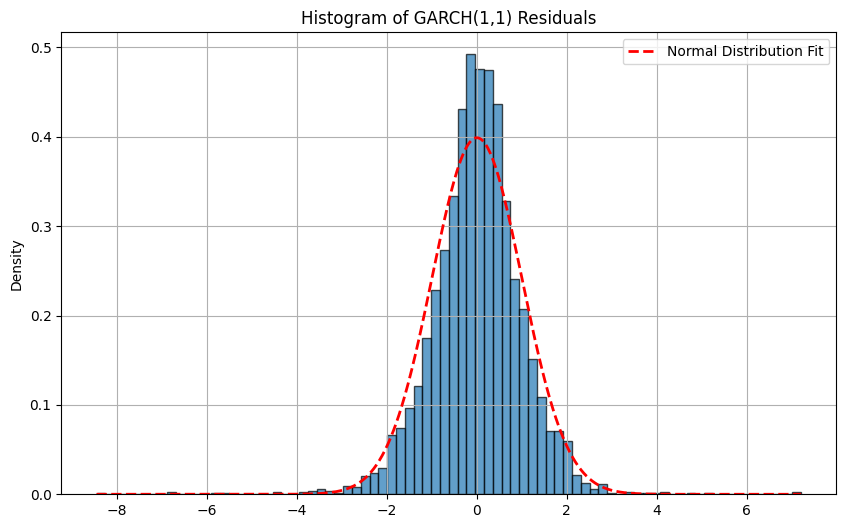

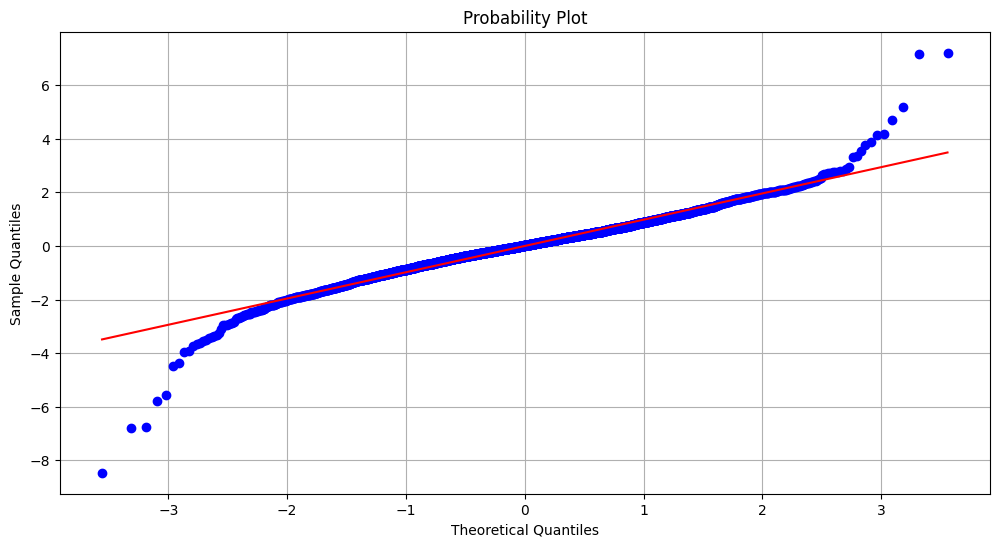

GARCH(1,1) Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2968.95
Distribution:                  Normal   AIC:                           5945.90
Method:            Maximum Likelihood   BIC:                           5970.77
                                        No. Observations:                 3701
Date:                Tue, Aug 27 2024   Df Residuals:                     3700
Time:                        04:36:50   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.9230e-03  8.390e

In [30]:
ar_fit_garch, garch_fit_ar,conditional_volatility_ar_garch = fit_ar_garch_model(usuk['log_return']*100,
                                             dist='normal',
                                             title='Normal Q-Q Plot of AR(7) - GARCH(1,1) Standardized  Residuals (Gaussian Assumption)')


print("GARCH(1,1) Model Summary:")
print(garch_fit_ar.summary())

- *AR(7)-GARCH(1,1) Model with Student Assumption*

AR fit summary:
                            AutoReg Model Results                             
Dep. Variable:             log_return   No. Observations:                 3708
Model:                     AutoReg(7)   Log Likelihood               -3328.385
Method:               Conditional MLE   S.D. of innovations              0.595
Date:                Tue, 27 Aug 2024   AIC                           6674.770
Time:                        04:36:50   BIC                           6730.717
Sample:                             7   HQIC                          6694.680
                                 3708                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0006      0.010     -0.059      0.953      -0.020       0.019
log_return.L1     0.0091      0.016      0.552      0.581      -0.023       0.041
log_return.L2     0.0006

c:\Users\wassim\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


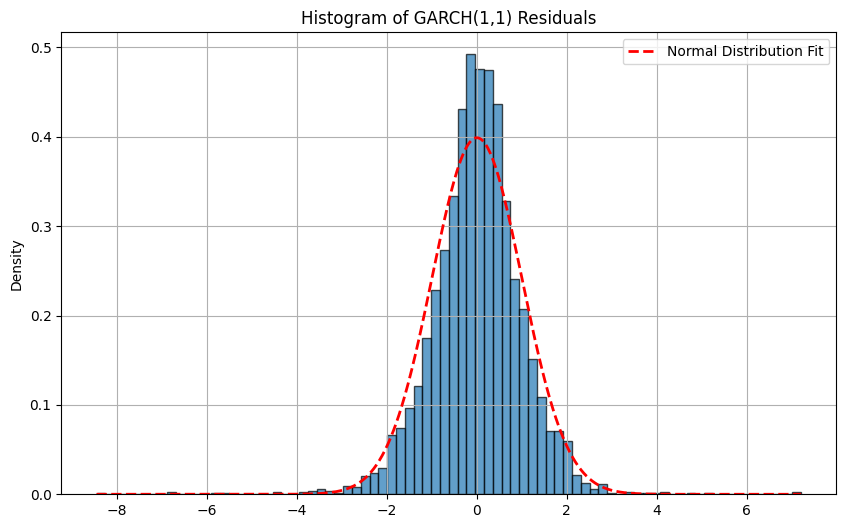

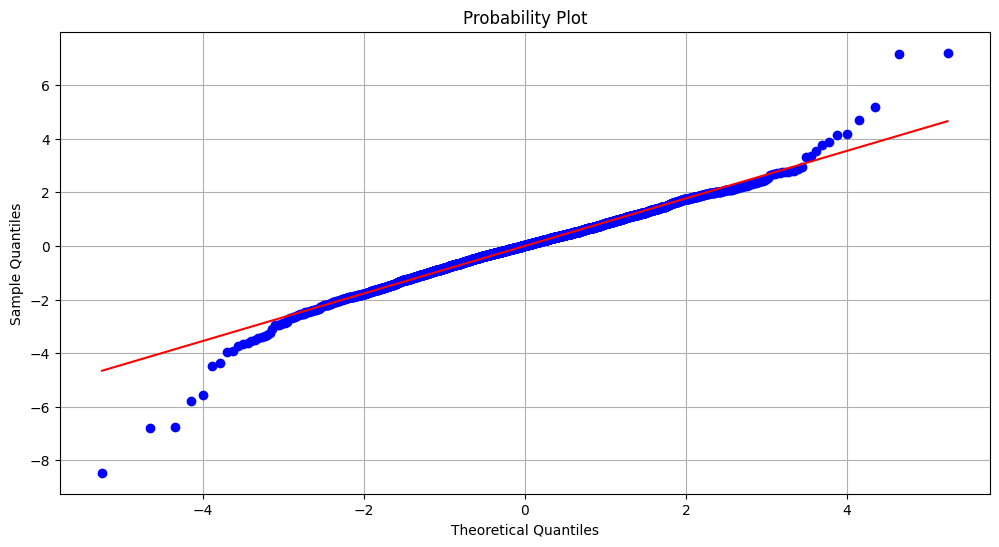

GARCH(1,1) Model Summary:
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2955.03
Distribution:      Standardized Student's t   AIC:                           5920.05
Method:                  Maximum Likelihood   BIC:                           5951.14
                                              No. Observations:                 3701
Date:                      Tue, Aug 27 2024   Df Residuals:                     3700
Time:                              04:36:50   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------

In [31]:
ar_fit_tgarch, tgarch_fit_ar,conditional_volatility_ar_tgarch = fit_ar_garch_model(usuk['log_return']*100,
                                             dist='studentst',
                                             title='Normal Q−Q Plot of AR(7) − GARCH(1,1) Standardized  Residuals (Student Assumption)')


print("GARCH(1,1) Model Summary:")
print(tgarch_fit_ar.summary())

In [32]:
# Let's compare both fitted AR(7)-GARCH(1,1) Models (Gaussian vs Student Distribution Assumptions)

print(garch_fit_ar.summary())
print('\n')
print(tgarch_fit_ar.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2968.95
Distribution:                  Normal   AIC:                           5945.90
Method:            Maximum Likelihood   BIC:                           5970.77
                                        No. Observations:                 3701
Date:                Tue, Aug 27 2024   Df Residuals:                     3700
Time:                        04:36:50   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.9230e-03  8.390e-03      0.944      0.345 

In [33]:
print(ar_fit_garch.summary())

print(ar_fit_tgarch.summary())

                            AutoReg Model Results                             
Dep. Variable:             log_return   No. Observations:                 3708
Model:                     AutoReg(7)   Log Likelihood               -3328.385
Method:               Conditional MLE   S.D. of innovations              0.595
Date:                Tue, 27 Aug 2024   AIC                           6674.770
Time:                        04:36:50   BIC                           6730.717
Sample:                             7   HQIC                          6694.680
                                 3708                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0006      0.010     -0.059      0.953      -0.020       0.019
log_return.L1     0.0091      0.016      0.553      0.580      -0.023       0.041
log_return.L2     0.0006      0.016     

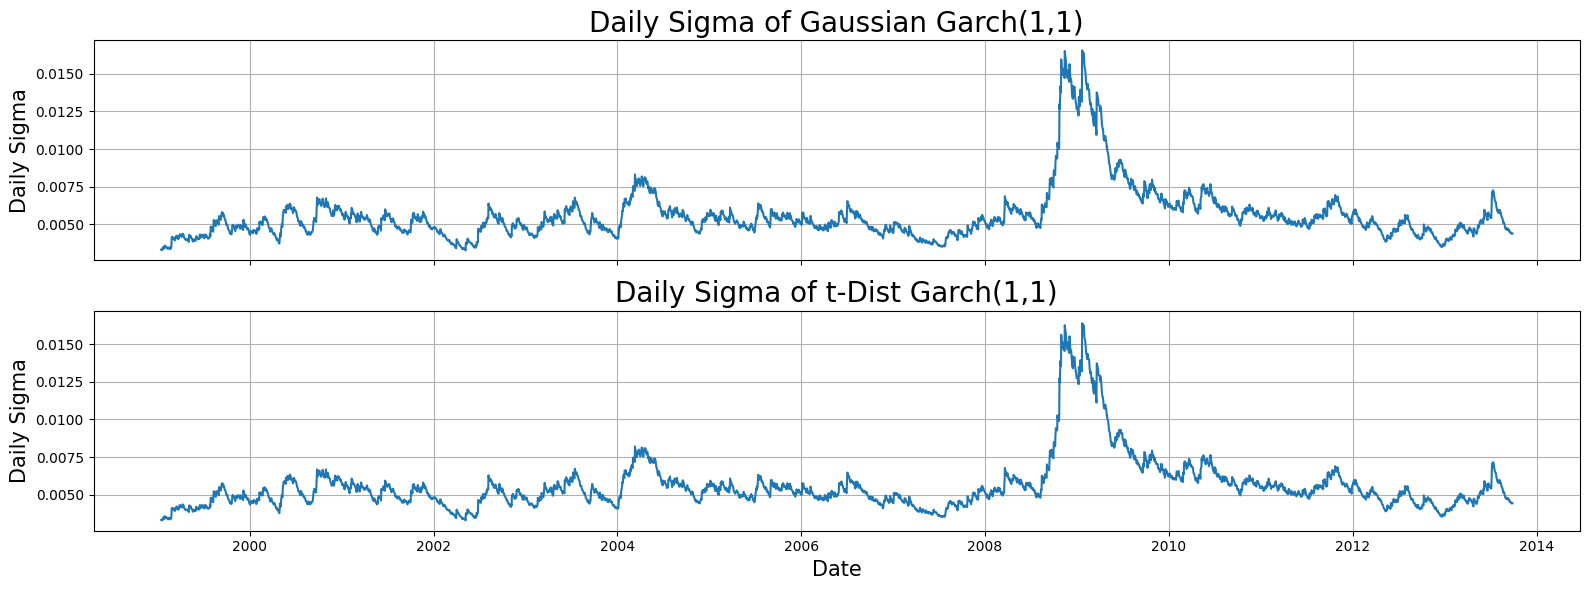

In [34]:
f, ax = plt.subplots(2,1,sharex=True,sharey=True)

ax = ax.flatten()

ax[0].plot(conditional_volatility_ar_garch/100)
ax[0].set_title('Daily Sigma of Gaussian Garch(1,1)',size=20)
ax[0].set_ylabel('Daily Sigma',size=15)

ax[1].plot(conditional_volatility_ar_tgarch/100)
ax[1].set_title('Daily Sigma of t-Dist Garch(1,1)',size=20)
ax[1].set_ylabel('Daily Sigma',size=15)

plt.xlabel('Date',size=15)

plt.tight_layout()

Note that the data usuk['log_return'] has been scaled by 100 due to some convergence problems (variance is too small for garch model), that's why I divided both cond. vol. by 100

Text(0, 0.5, 'Difference in Daily Sigma')

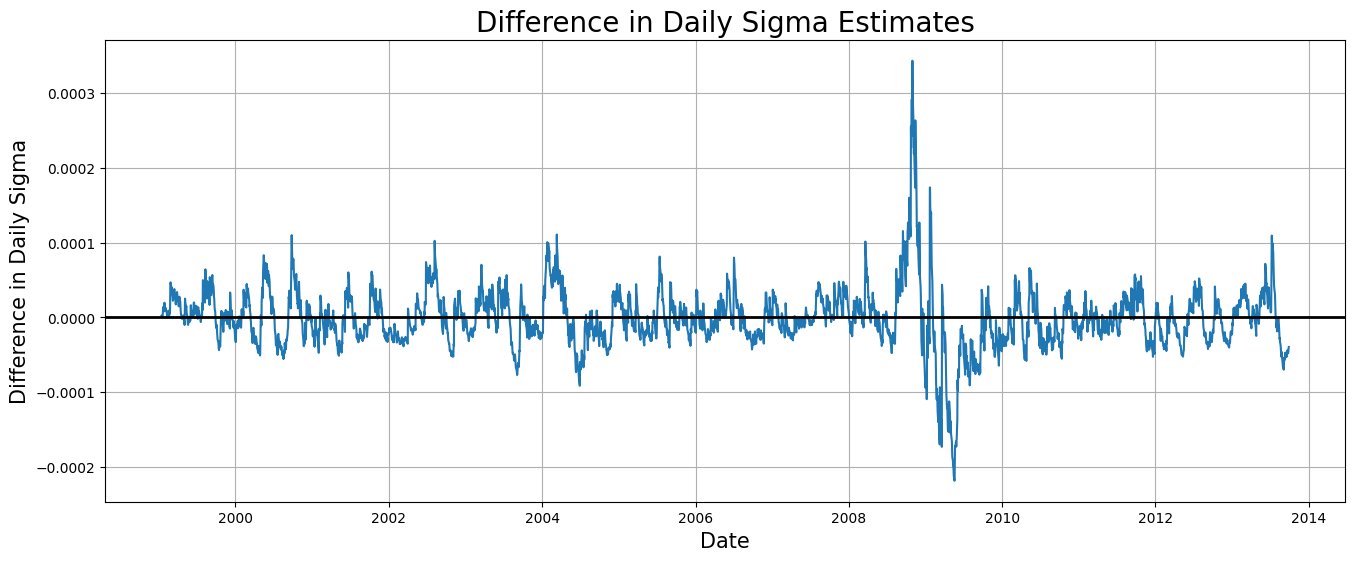

In [42]:
difference = conditional_volatility_ar_garch - conditional_volatility_ar_tgarch

plt.plot(difference/100)
plt.axhline(y=0,color='black',lw=2)

plt.title('Difference in Daily Sigma Estimates',size=20)
plt.xlabel('Date',size=15)
plt.ylabel('Difference in Daily Sigma',size=15)

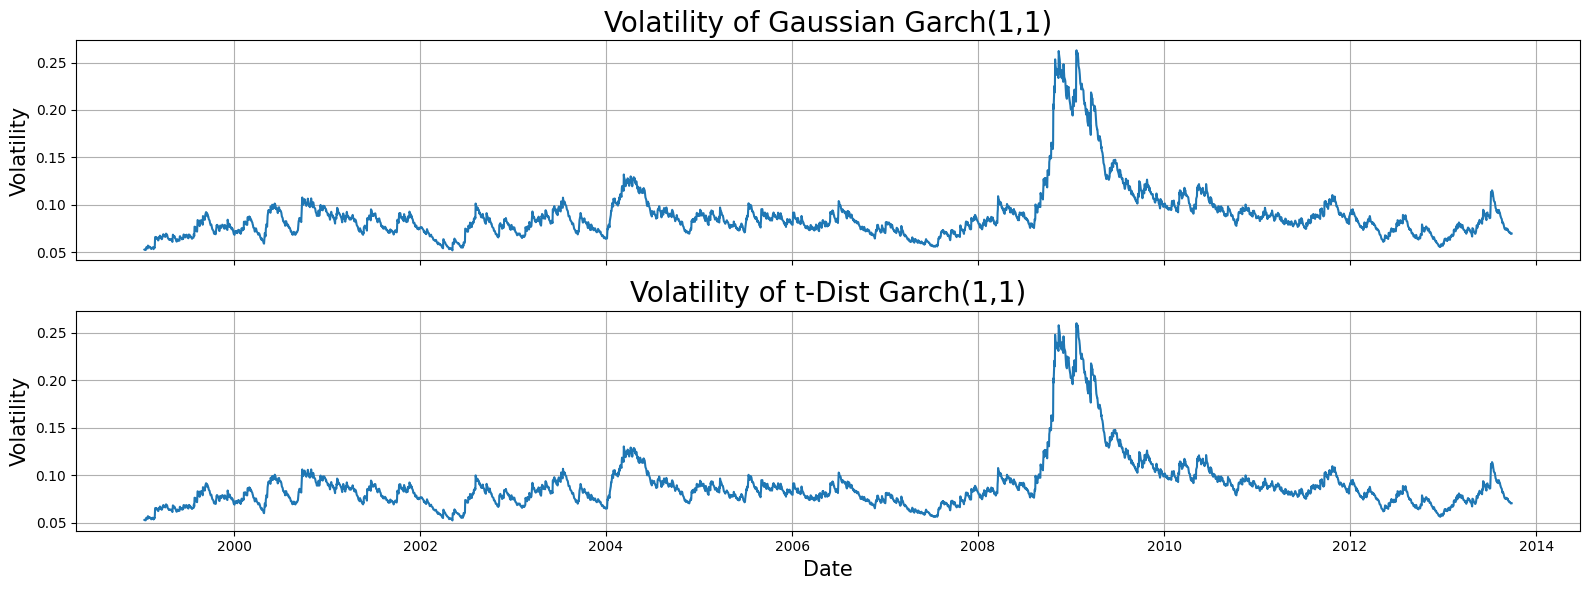

In [36]:
# Re-do plot on volatility (annualized st. dev.) scale

f, ax = plt.subplots(2,1,sharex=True,sharey=True)

ax = ax.flatten()

ax[0].plot(conditional_volatility_ar_garch*np.sqrt(252)/100)
ax[0].set_title('Volatility of Gaussian Garch(1,1)',size=20)
ax[0].set_ylabel('Volatility',size=15)

ax[1].plot(conditional_volatility_ar_tgarch*np.sqrt(252)/100)
ax[1].set_title('Volatility of t-Dist Garch(1,1)',size=20)
ax[1].set_ylabel('Volatility',size=15)

plt.xlabel('Date',size=15)

plt.tight_layout()

Text(0, 0.5, 'Difference in Volatility')

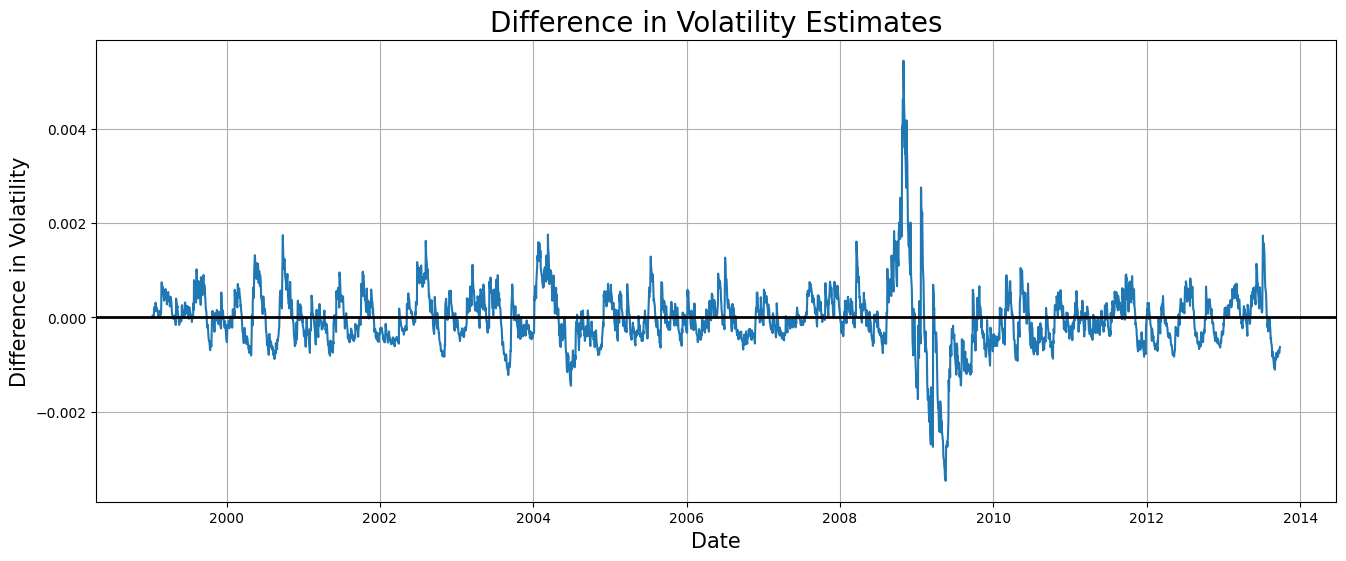

In [41]:
difference_annualized = (conditional_volatility_ar_garch - conditional_volatility_ar_tgarch)*np.sqrt(252)

plt.plot(difference_annualized/100)
plt.axhline(y=0,color='black',lw=2)

plt.title('Difference in Volatility Estimates',size=20)
plt.xlabel('Date',size=15)
plt.ylabel('Difference in Volatility',size=15)

- *Value at Risk and Expected Shortfall for AR(7)-GARCH(1,1) Model with Normal vs t-Distribution.*

In [38]:
def plot_VaR_ES(data, ar_fit, garch_fit, dist='normal', df=None, quantile_level=0.025):
    
    """
    Plot Value at Risk (VaR) and Expected Shortfall (ES) limits for the AR-GARCH model with specified distribution innovations.

    Parameters:
    - data: Series of returns.
    - ar_fit: Fitted AR model.
    - garch_fit: Fitted GARCH model.
    - dist: Distribution type for VaR and ES calculation ('normal' or 'student').
    - df: Degrees of freedom for the t-distribution (only used if dist='student').
    - quantile_level: Quantile level for VaR and ES calculation (e.g., 0.025 for 2.5%).
    """
    
    sigma = garch_fit.conditional_volatility/100

    long_term_mean = ar_fit.params.iloc[0] / (1 - np.sum(ar_fit.params.iloc[1:]))
    
    if dist == 'normal':
        norm_quantile_lo = norm.ppf(quantile_level)
        norm_quantile_hi = norm.ppf(1 - quantile_level)
        var_limit_lo = long_term_mean + norm_quantile_lo * sigma
        var_limit_hi = long_term_mean + norm_quantile_hi * sigma
        
        es_lo = long_term_mean - sigma * norm.pdf(norm_quantile_lo) / quantile_level
        es_hi = long_term_mean + sigma * norm.pdf(norm_quantile_hi) / quantile_level
        
        label_var_lo = 'VaR Low Limit (Normal)'
        label_var_hi = 'VaR High Limit (Normal)'
        label_es_lo = 'ES Low Limit (Normal)'
        label_es_hi = 'ES High Limit (Normal)'
    
    elif dist == 'student':
        if df is None:
            df = garch_fit.params.iloc[-1].round()
        t_quantile_lo = t.ppf(quantile_level, df=df)
        t_quantile_hi = t.ppf(1 - quantile_level, df=df)
        var_limit_lo = long_term_mean + t_quantile_lo * sigma 
        var_limit_hi = long_term_mean + t_quantile_hi * sigma 
        
        es_lo = long_term_mean - sigma * (df + t_quantile_lo**2) / ((df - 1) * quantile_level) * t.pdf(t_quantile_lo, df)
        es_hi = long_term_mean + sigma * (df + t_quantile_hi**2) / ((df - 1) * quantile_level) * t.pdf(t_quantile_hi, df)
        
        label_var_lo = f'VaR Low Limit (t-dist, df={df})'
        label_var_hi = f'VaR High Limit (t-dist, df={df})'
        label_es_lo = f'ES Low Limit (t-dist, df={df})'
        label_es_hi = f'ES High Limit (t-dist, df={df})'
    
    else:
        raise ValueError("Unsupported distribution type. Use 'normal' or 'student'.")

    plt.plot(data, color='blue', label='Returns', alpha=0.5)
    plt.plot(var_limit_lo, color='red', label=label_var_lo)
    plt.plot(var_limit_hi, color='green', label=label_var_hi)
    plt.plot(es_lo, color='orange', label=label_es_lo)
    plt.plot(es_hi, color='orange', label=label_es_hi)
    plt.axhline(y=0, color='black', lw=1)
    
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.title(f'Series with {round(quantile_level * 100, 1)}% VaR and ES Limits ({dist.capitalize()})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"VaR (Low): {var_limit_lo.mean():.4f}")
    print(f"VaR (High): {var_limit_hi.mean():.4f}")
    print(f"ES (Low): {es_lo.mean():.4f}")
    print(f"ES (High): {es_hi.mean():.4f}")

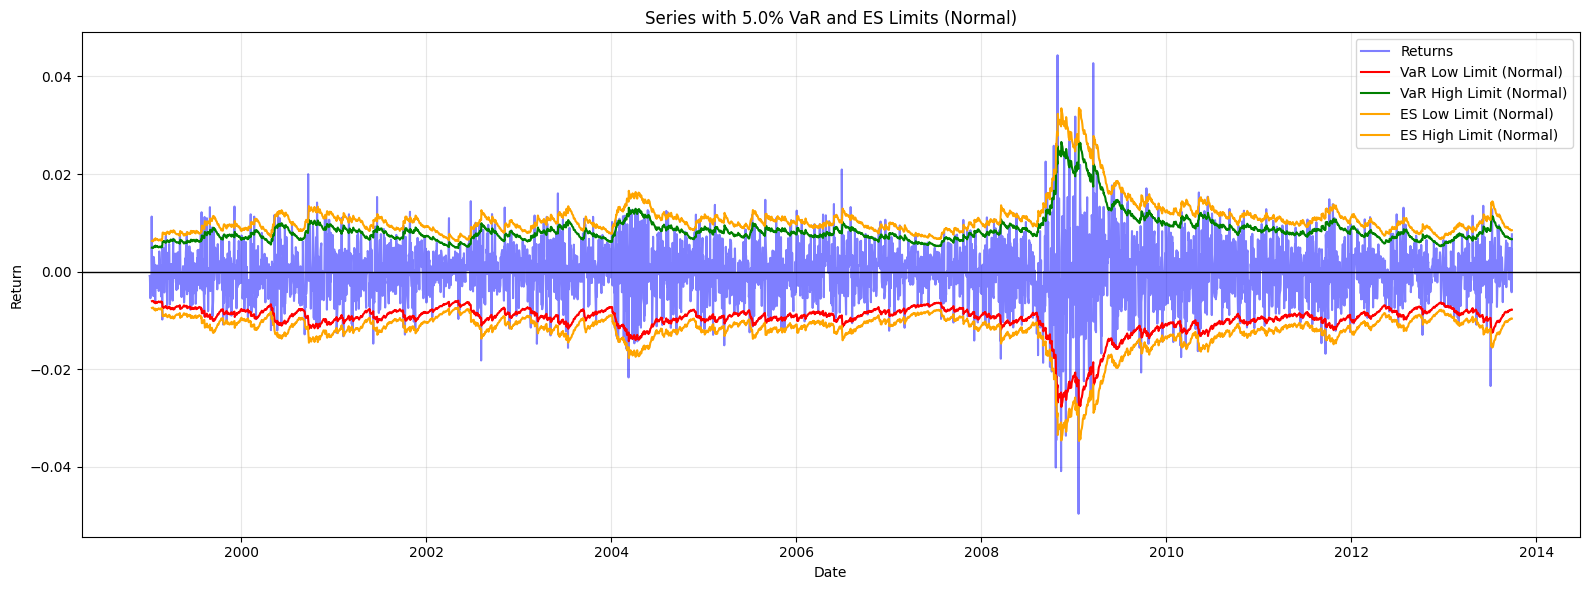

VaR (Low): -0.0098
VaR (High): 0.0086
ES (Low): -0.0121
ES (High): 0.0110


In [39]:
plot_VaR_ES(usuk['log_return'], ar_fit_garch, garch_fit_ar,dist='normal', quantile_level=0.05)

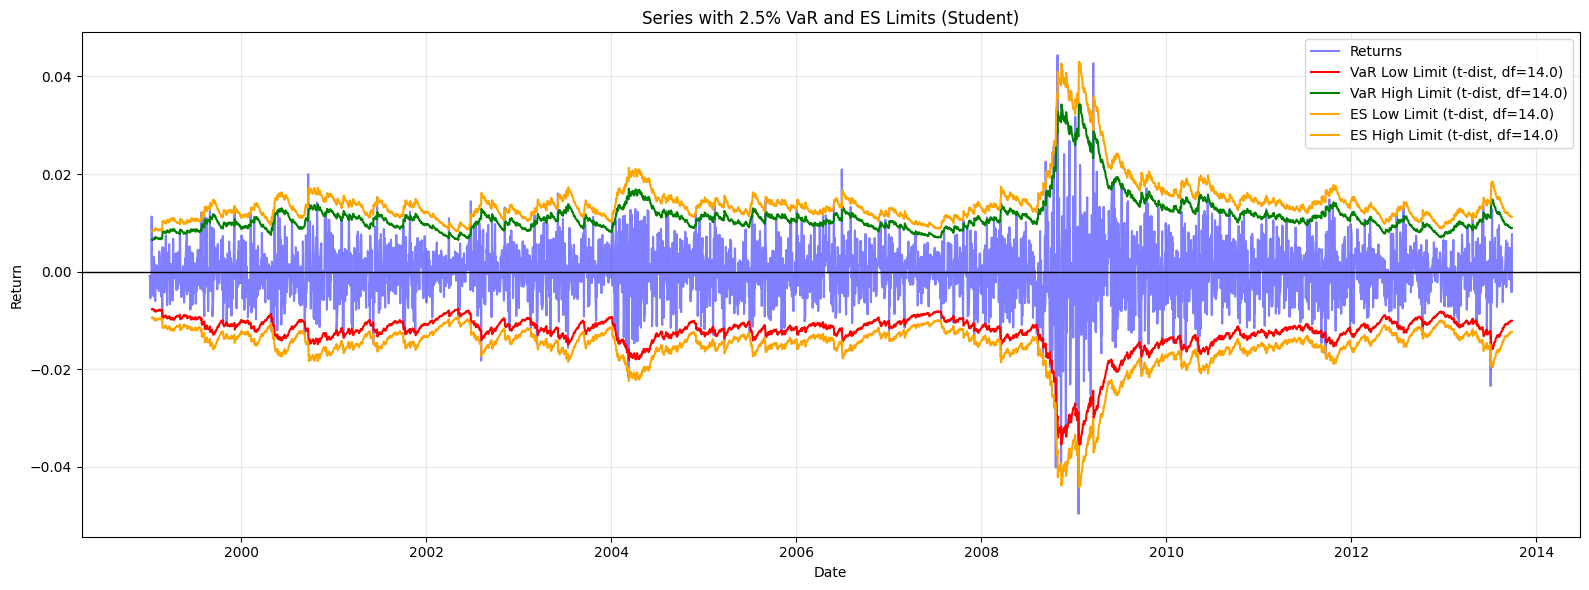

VaR (Low): -0.0126
VaR (High): 0.0114
ES (Low): -0.0155
ES (High): 0.0143


In [40]:
plot_VaR_ES(usuk['log_return'], ar_fit_tgarch, tgarch_fit_ar,dist='student', quantile_level=0.025)